In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scvi
import pickle
import os
import scipy
import seaborn as sns
from datetime import datetime
#%env CUDA_VISIBLE_DEVICES=3
import torch
from utils import sample_pt_cells_scvi, viz_props
print("cuda available: " + str(torch.cuda.is_available()))

Global seed set to 0


cuda available: True


In [2]:
cd45_adata = sc.read_h5ad("/localdata/rna_rep_learning/zavidij_etal/cd45_adata.h5ad")

In [2]:
adata = sc.read_h5ad("/localdata/rna_rep_learning/scset/props_exp_scvi_tsubtypes_0.25vs0.1_dirstr100.h5ad")

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/rpeyser/GitHub/scSet/datasets/utils.py:103: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  obs_df.celltype.cat.remove_unused_categories(inplace=True)
/home/rpeyser/GitHub/scSet/datasets/utils.py:107: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pt_totalcells = celltypecounts.groupby("patient").sum().iloc[:,[0]].reset_index().rename(columns={'ncells':'pt_totalcells'})


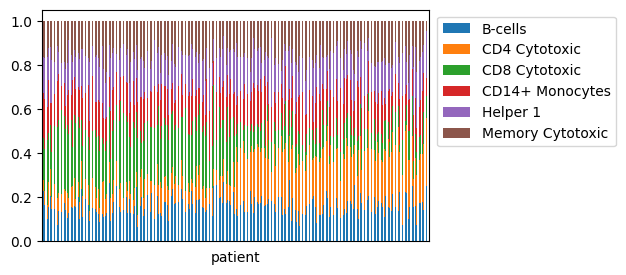

In [3]:
viz_props(adata.obs)

# Train sep B and T cell models, sample 1 sample per cell

In [3]:
def train_scvi_on_subtype(adata, subtype):
    sub_adata = adata[adata.obs.celltype==subtype].copy()
    print(sub_adata)
    scvi.model.SCVI.setup_anndata(sub_adata)
    model = scvi.model.SCVI(sub_adata, n_hidden=128, n_latent=10, n_layers=1, dropout_rate=0.1, dispersion='gene', gene_likelihood='nb', latent_distribution='normal')
    model.train()
    return(model)


In [ ]:
Bcellmodel = train_scvi_on_subtype(cd45_adata, "B-cells")               

In [5]:
Tcellmodel = train_scvi_on_subtype(cd45_adata, "T-cells")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


AnnData object with n_obs × n_vars = 10141 × 23776
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'samp.no', 'sample', 'patient', 'mark', 'percent.mito', 'disease', 'IgType', 'batch', 'vial', 'disease.long', 'pct.IG', 'res.0.6', 'full.cluster', 'res.1.4', 'clust1.4', 'celltype', 'patient.bc', 'ident', 'Tcellsubtype'
    layers: 'logcounts'
Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [07:30<00:00,  1.00it/s, loss=2.29e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [07:30<00:00,  1.13s/it, loss=2.29e+03, v_num=1]


In [219]:
monocyte_model = train_scvi_on_subtype(cd45_adata, 'CD14+ Monocytes')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


AnnData object with n_obs × n_vars = 3101 × 23776
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'samp.no', 'sample', 'patient', 'mark', 'percent.mito', 'disease', 'IgType', 'batch', 'vial', 'disease.long', 'pct.IG', 'res.0.6', 'full.cluster', 'res.1.4', 'clust1.4', 'celltype', 'patient.bc', 'ident', 'Tcellsubtype'
    layers: 'logcounts'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:16<00:00,  2.88it/s, loss=2.71e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:16<00:00,  2.93it/s, loss=2.71e+03, v_num=1]


In [9]:
#dump trained scVI objects
with open("/localdata/rna_rep_learning/scset/scvi_data/Tcellmodel.pkl", "wb") as f: # "wb" because we want to write in binary mode
    pickle.dump(Tcellmodel, f)
    
with open("/localdata/rna_rep_learning/scset/scvi_data/Bcellmodel.pkl", "wb") as f: # "wb" because we want to write in binary mode
    pickle.dump(Bcellmodel, f)

In [220]:
with open("/localdata/rna_rep_learning/scset/scvi_data/cd14monocytemodel.pkl", "wb") as f: # "wb" because we want to write in binary mode
    pickle.dump(monocyte_model, f)

In [4]:
#load trained scVI objects
with open("/localdata/rna_rep_learning/scset/scvi_data/Tcellmodel.pkl", "rb") as f: # "wb" because we want to write in binary mode
    Tcellmodel = pickle.load(f)
    
with open("/localdata/rna_rep_learning/scset/scvi_data/Bcellmodel.pkl", "rb") as f: # "wb" because we want to write in binary mode
    Bcellmodel = pickle.load(f)
    
with open("/localdata/rna_rep_learning/scset/scvi_data/cd14monocytemodel.pkl", "rb") as f: # "wb" because we want to write in binary mode
    monocyte_model = pickle.load(f)    

In [189]:
Bcellsamples = Bcellmodel.posterior_predictive_sample(n_samples=1)

In [190]:
Tcellsamples = Tcellmodel.posterior_predictive_sample(n_samples=1)

In [195]:
joint_obs = pd.concat([cd45_adata.obs[cd45_adata.obs.celltype=="B-cells"],cd45_adata.obs[cd45_adata.obs.celltype=="T-cells"]]) [["patient","celltype","Tcellsubtype"]].reset_index().rename(columns={"index":"orig_cellbarcode"})
joint_obs.head()

orig_cellbarcode patient celltype Tcellsubtype
0   TACGGGCCAGGTCGTC-9    MM-3  B-cells          NaN
1  ACTGTCCCAAGGGTCA-12    MM-4  B-cells          NaN
2  CAGTAACCACACCGAC-12    MM-4  B-cells          NaN
3  GTGCTTCCAGGATTGG-12    MM-4  B-cells          NaN
4  TGTGGTATCTCCAACC-12    MM-4  B-cells          NaN

In [196]:
joint_adata = sc.AnnData(
    np.concatenate((Bcellsamples, Tcellsamples), axis=0), 
    obs = joint_obs,
    var = cd45_adata.var
)


/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


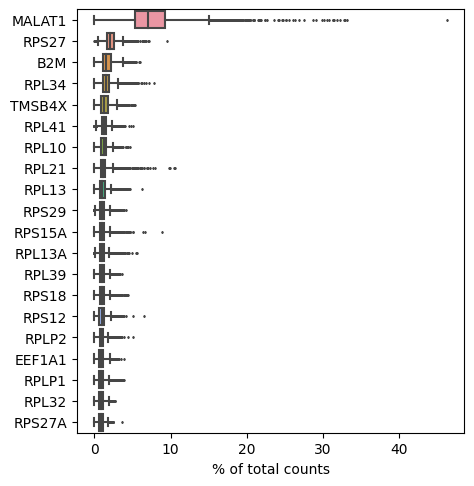

In [197]:
sc.pl.highest_expr_genes(joint_adata, n_top=20, )


In [198]:
sc.pp.filter_cells(joint_adata, min_genes=200)
sc.pp.filter_genes(joint_adata, min_cells=3)

In [199]:
joint_adata.var['mt'] = joint_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(joint_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

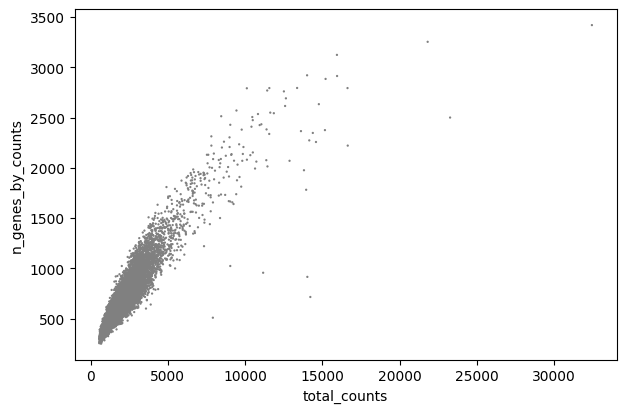

In [200]:
sc.pl.scatter(joint_adata, x='total_counts', y='n_genes_by_counts')

In [201]:
joint_adata.layers['counts'] = joint_adata.X.copy()

sc.pp.normalize_total(joint_adata, target_sum=1e4)

In [202]:
sc.pp.log1p(joint_adata)


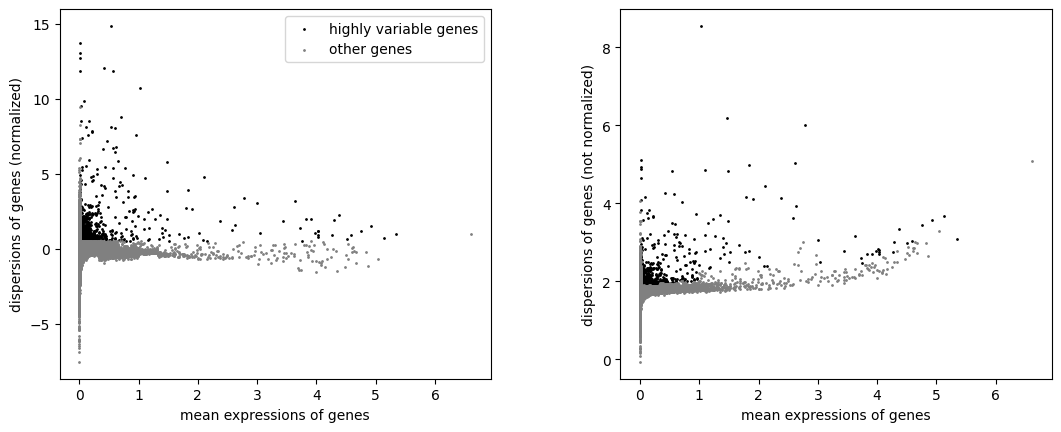

In [203]:
sc.pp.highly_variable_genes(joint_adata, min_mean=0.0125, max_mean=6, min_disp=0.5)
sc.pl.highly_variable_genes(joint_adata)


In [204]:
joint_adata.layers['lognorm'] = joint_adata.X.copy()


In [205]:
sc.pp.scale(joint_adata, max_value=10)


In [206]:
sc.tl.pca(joint_adata, svd_solver='arpack')


/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


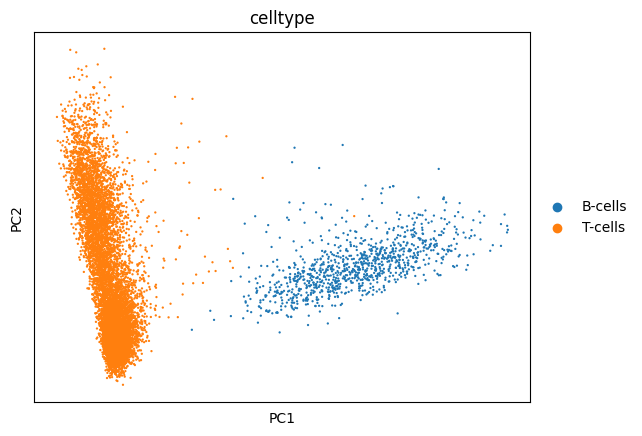

In [207]:
sc.pl.pca(joint_adata, color='celltype')


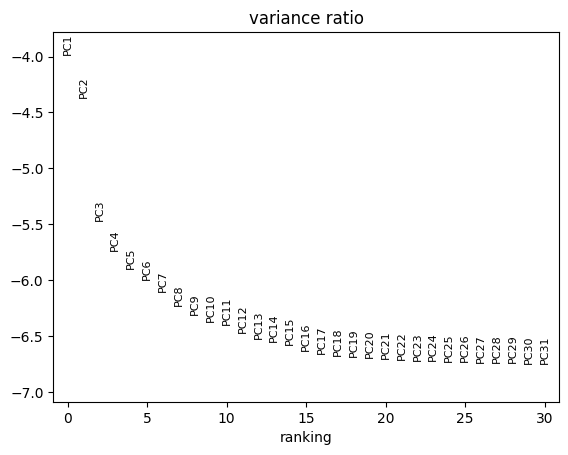

In [208]:
sc.pl.pca_variance_ratio(joint_adata, log=True)


In [209]:
sc.pp.neighbors(joint_adata, n_neighbors=10, n_pcs=20)


In [210]:
sc.tl.umap(joint_adata)

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


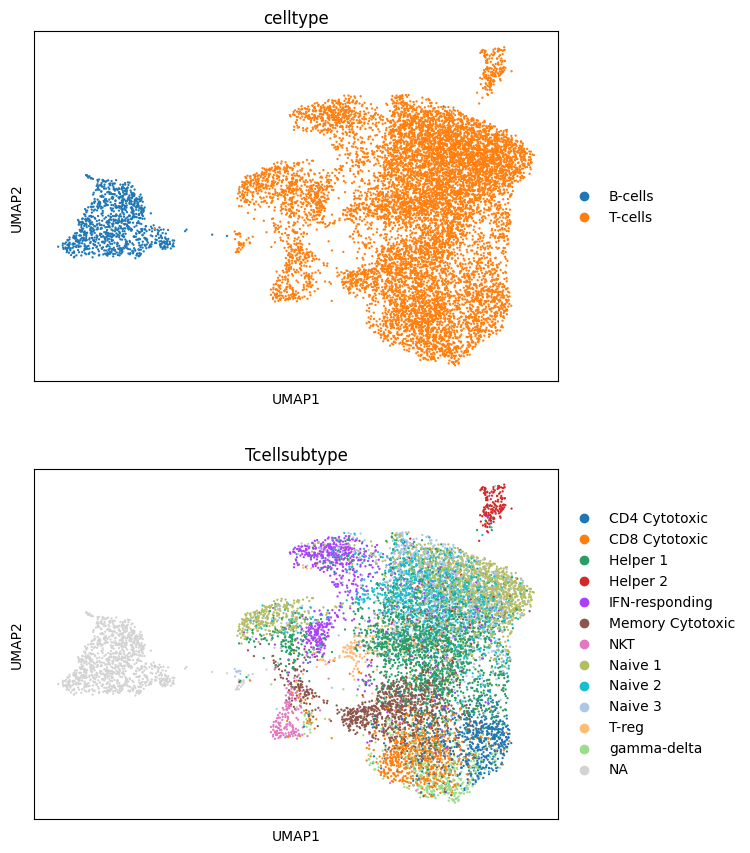

In [211]:
sc.pl.umap(joint_adata, color=['celltype', 'Tcellsubtype'], ncols=1)


# Do we get same reuslts if train one model on all cells, and then sample from cell types of interest?

In [3]:
scvi.model.SCVI.setup_anndata(cd45_adata)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [225]:
fullmodel = scvi.model.SCVI(cd45_adata, n_hidden=128, n_latent=10, n_layers=1, dropout_rate=0.1, dispersion='gene', gene_likelihood='nb', latent_distribution='normal')
fullmodel.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Epoch 400/400: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [13:22<00:00,  2.03s/it, loss=2.7e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [13:22<00:00,  2.01s/it, loss=2.7e+03, v_num=1]


In [226]:
#dump trained scVI objects
with open("/localdata/rna_rep_learning/scset/scvi_data/cd45model.pkl", "wb") as f: # "wb" because we want to write in binary mode
    pickle.dump(fullmodel, f)

In [3]:
with open("/localdata/rna_rep_learning/scset/scvi_data/cd45model.pkl", "rb") as f: # "wb" because we want to write in binary mode
    fullmodel = pickle.load(f)   

In [6]:
Bcell_inds = np.arange(len(cd45_adata))[cd45_adata.obs.celltype=="B-cells"]
Tcell_inds = np.arange(len(cd45_adata))[cd45_adata.obs.celltype=="T-cells"]
mono_inds = np.arange(len(cd45_adata))[cd45_adata.obs.celltype=='CD14+ Monocytes']

In [7]:
Bcellsamples = fullmodel.posterior_predictive_sample(indices=Bcell_inds, n_samples=1)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [8]:
Tcellsamples = fullmodel.posterior_predictive_sample(indices=Tcell_inds, n_samples=1)
monosamples = fullmodel.posterior_predictive_sample(indices=mono_inds, n_samples=1)

In [9]:
joint_obs = pd.concat([cd45_adata.obs[cd45_adata.obs.celltype=="B-cells"],cd45_adata.obs[cd45_adata.obs.celltype=="T-cells"],cd45_adata.obs[cd45_adata.obs.celltype=="CD14+ Monocytes"]]) [["patient","celltype","Tcellsubtype"]].reset_index().rename(columns={"index":"orig_cellbarcode"})
joint_obs.head()

orig_cellbarcode patient celltype Tcellsubtype
0   TACGGGCCAGGTCGTC-9    MM-3  B-cells          NaN
1  ACTGTCCCAAGGGTCA-12    MM-4  B-cells          NaN
2  CAGTAACCACACCGAC-12    MM-4  B-cells          NaN
3  GTGCTTCCAGGATTGG-12    MM-4  B-cells          NaN
4  TGTGGTATCTCCAACC-12    MM-4  B-cells          NaN

In [234]:
joint_adata = sc.AnnData(
    np.concatenate((Bcellsamples, Tcellsamples, monosamples), axis=0), 
    obs = joint_obs,
    var = cd45_adata.var
)


/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


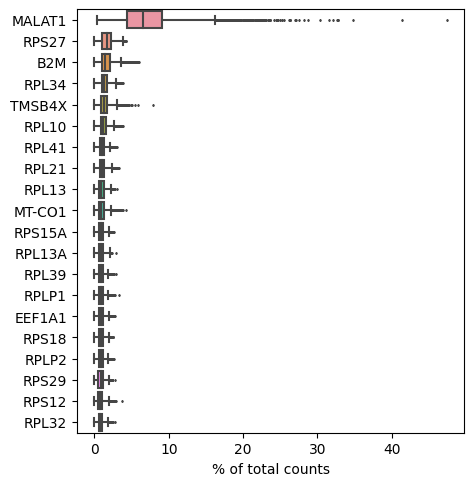

In [235]:
sc.pl.highest_expr_genes(joint_adata, n_top=20, )


In [236]:
sc.pp.filter_cells(joint_adata, min_genes=200)
sc.pp.filter_genes(joint_adata, min_cells=3)

In [237]:
joint_adata.var['mt'] = joint_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(joint_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

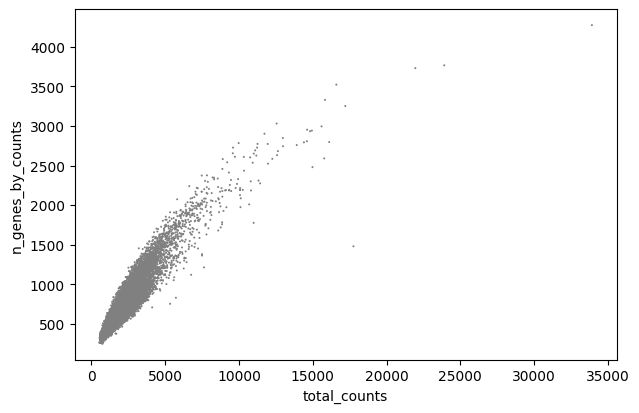

In [238]:
sc.pl.scatter(joint_adata, x='total_counts', y='n_genes_by_counts')

In [239]:
joint_adata.layers['counts'] = joint_adata.X.copy()

sc.pp.normalize_total(joint_adata, target_sum=1e4)

In [240]:
sc.pp.log1p(joint_adata)


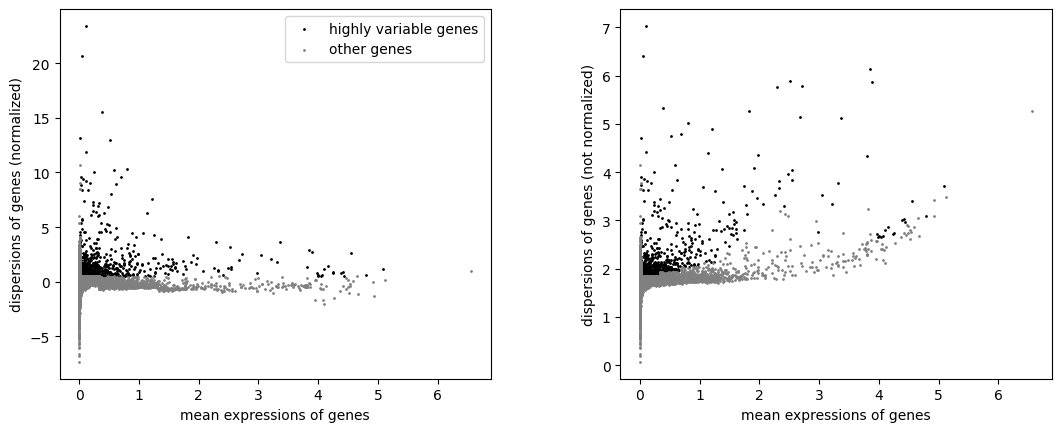

In [241]:
sc.pp.highly_variable_genes(joint_adata, min_mean=0.0125, max_mean=6, min_disp=0.5)
sc.pl.highly_variable_genes(joint_adata)


In [242]:
joint_adata.layers['lognorm'] = joint_adata.X.copy()


In [243]:
sc.pp.scale(joint_adata, max_value=10)


In [244]:
sc.tl.pca(joint_adata, svd_solver='arpack')


/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


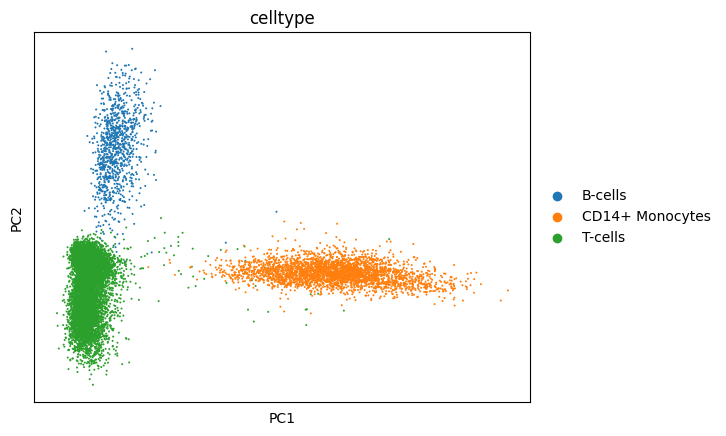

In [245]:
sc.pl.pca(joint_adata, color='celltype')


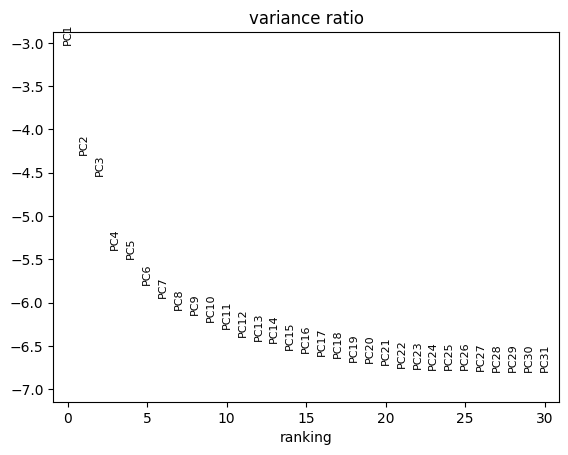

In [246]:
sc.pl.pca_variance_ratio(joint_adata, log=True)


In [247]:
sc.pp.neighbors(joint_adata, n_neighbors=10, n_pcs=20)


In [248]:
sc.tl.umap(joint_adata)

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


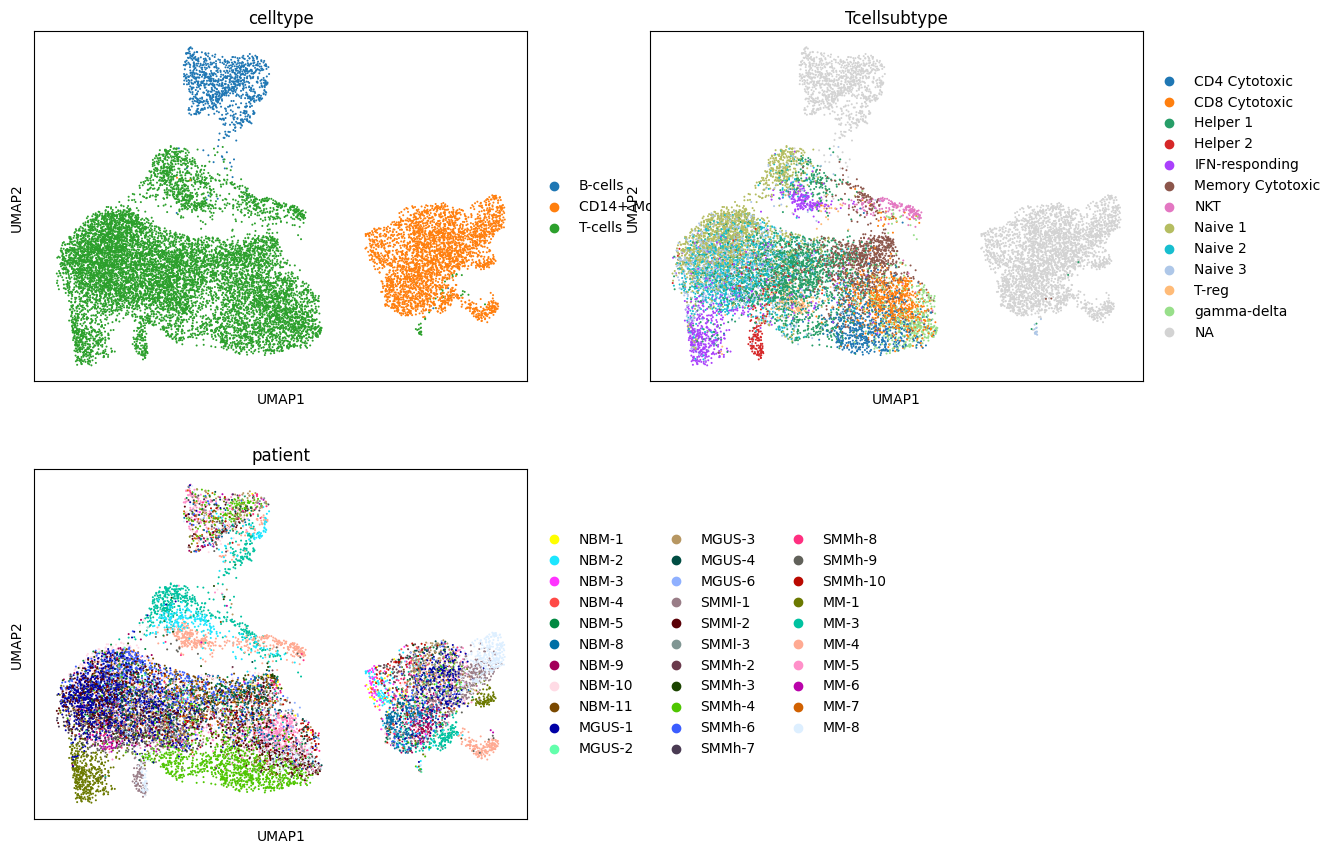

In [252]:
sc.pl.umap(joint_adata, color=['celltype', 'Tcellsubtype', 'patient'], ncols=2)


# Create dataset of patient with differing proportions of cells (B, T, monocyte)

In [3]:
scvi.model.SCVI.setup_anndata(cd45_adata)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [224]:
#calculating mean_ncells
cd45_adata.obs[cd45_adata.obs.celltype.isin(['B-cells','T-cells','CD14+ Monocytes'])].groupby('patient').size().mean()

445.21875

In [253]:
cd45_adata.obs.celltype.value_counts()

T-cells            10141
CD14+ Monocytes     3101
NK cells            2100
B-cells             1005
HPCs                 656
CD16+ Monocytes      631
mDCs                 420
pre-B-cells          420
pDCs                 318
Neutrophils          235
Name: celltype, dtype: int64

In [137]:
cd45_adata.obs.groupby('patient').size().mean()#.value_counts()

594.59375

In [35]:
cell_types = ["T-cell", "B-cell", "monocytes"]
cell_type_dirichlet_concentrations_1={"T-cell":0.65*100, "B-cell":0.1*100, "monocytes":0.25*100}
cell_type_dirichlet_concentrations_2={"T-cell":0.65*100, "B-cell":0.25*100, "monocytes":0.1*100}
npatients = 500
mean_ncells = 445
total_cells_pp = scipy.stats.poisson.rvs(mean_ncells, size=npatients)
sim_counts = np.empty((np.sum(total_cells_pp), cd45_adata.shape[1]))
verbose=False

# full list of inds per cell type
Bcell_inds = np.arange(len(cd45_adata))[cd45_adata.obs.celltype=="B-cells"]
Tcell_inds = np.arange(len(cd45_adata))[cd45_adata.obs.celltype=="T-cells"]
mono_inds = np.arange(len(cd45_adata))[cd45_adata.obs.celltype=='CD14+ Monocytes']
        

cell_index = 0
for i in np.arange(npatients):
    
    if i <=(npatients/2-1):    
        sample_cell_type_probs = scipy.stats.dirichlet.rvs([cell_type_dirichlet_concentrations_1[i] for i in cell_types]).squeeze() #ensures cell_type_concs is indexed in same order as cell_types 
        cell_type_counts = scipy.stats.multinomial.rvs(total_cells_pp[i], sample_cell_type_probs)
        
        ## sample B, T, mono in certain proportions
        #sample
        T_chosen_inds = np.random.choice(Tcell_inds, size = cell_type_counts[0])
        B_chosen_inds = np.random.choice(Bcell_inds, size = cell_type_counts[1])
        mono_chosen_inds = np.random.choice(mono_inds, size = cell_type_counts[2])
        
        Tcellsamples = fullmodel.posterior_predictive_sample(indices=T_chosen_inds, n_samples=1)
        Bcellsamples = fullmodel.posterior_predictive_sample(indices=B_chosen_inds, n_samples=1)
        monocytesamples = fullmodel.posterior_predictive_sample(indices=mono_chosen_inds, n_samples=1)
        
        joint_obs = pd.concat([cd45_adata.obs.iloc[T_chosen_inds,:],
                               cd45_adata.obs.iloc[B_chosen_inds,:],
                               cd45_adata.obs.iloc[mono_chosen_inds,:]]) [["patient","celltype","Tcellsubtype"]].reset_index().rename(columns={"index":"orig_cellbarcode", "patient":"patient_orig"})
        joint_obs["group"] = pd.Series("more_mono").repeat(total_cells_pp[i]).reset_index(drop=True)
        joint_obs["patient"] = pd.Series("sim_pt{}".format(i+1)).repeat(total_cells_pp[i]).reset_index(drop=True)
        sim_counts[cell_index:cell_index+total_cells_pp[i],:] = np.concatenate((Tcellsamples, Bcellsamples, monocytesamples), axis=0)

    else:
        sample_cell_type_probs = scipy.stats.dirichlet.rvs([cell_type_dirichlet_concentrations_2[i] for i in cell_types]).squeeze() #ensures cell_type_concs is indexed in same order as cell_types 
        cell_type_counts = scipy.stats.multinomial.rvs(total_cells_pp[i], sample_cell_type_probs)
        
        ## sample B, T, mono in certain proportions
        #sample
        T_chosen_inds = np.random.choice(Tcell_inds, size = cell_type_counts[0])
        B_chosen_inds = np.random.choice(Bcell_inds, size = cell_type_counts[1])
        mono_chosen_inds = np.random.choice(mono_inds, size = cell_type_counts[2])
        
        Tcellsamples = fullmodel.posterior_predictive_sample(indices=T_chosen_inds, n_samples=1)
        Bcellsamples = fullmodel.posterior_predictive_sample(indices=B_chosen_inds, n_samples=1)
        monocytesamples = fullmodel.posterior_predictive_sample(indices=mono_chosen_inds, n_samples=1)
        
        joint_obs = pd.concat([cd45_adata.obs.iloc[T_chosen_inds,:],
                               cd45_adata.obs.iloc[B_chosen_inds,:],
                               cd45_adata.obs.iloc[mono_chosen_inds,:]]) [["patient","celltype","Tcellsubtype"]].reset_index().rename(columns={"index":"orig_cellbarcode", "patient":"patient_orig"})
        joint_obs["group"] = pd.Series("more_B").repeat(total_cells_pp[i]).reset_index(drop=True)
        joint_obs["patient"] = pd.Series("sim_pt{}".format(i+1)).repeat(total_cells_pp[i]).reset_index(drop=True)
        sim_counts[cell_index:cell_index+total_cells_pp[i],:] = np.concatenate((Tcellsamples, Bcellsamples, monocytesamples), axis=0)
        
    cell_index += total_cells_pp[i]
    if i==0:
        sim_metadata = joint_obs.copy()
    else: 
        sim_metadata = pd.concat([sim_metadata, joint_obs], axis=0)


In [36]:
sim_counts.shape

(223020, 23776)

In [37]:
sim_metadata.shape

(223020, 6)

In [38]:
sim_metadata.head()

orig_cellbarcode patient_orig celltype      Tcellsubtype      group  \
0   ATCACGATCAGTTCGA-3         MM-1  T-cells    IFN-responding  more_mono   
1  CTCGGGACAAGAAGAG-57       MGUS-1  T-cells           Naive 2  more_mono   
2  TGCGCAGTCATCACCC-47       SMMh-6  T-cells          Helper 1  more_mono   
3  CCTTACGTCCTTAATC-14         MM-5  T-cells     CD8 Cytotoxic  more_mono   
4  TACGGTACATCCCATC-55       SMMl-1  T-cells  Memory Cytotoxic  more_mono   

   patient  
0  sim_pt1  
1  sim_pt1  
2  sim_pt1  
3  sim_pt1  
4  sim_pt1

In [39]:
sim_adata = sc.AnnData(sim_counts, obs=sim_metadata, var = cd45_adata.var)

sim_adata.layers['counts'] = sim_adata.X.copy()

sc.pp.normalize_total(sim_adata, target_sum=1e4)


/tmp/ipykernel_3907105/3692567192.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  sim_adata = sc.AnnData(sim_counts, obs=sim_metadata, var = cd45_adata.var)
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [40]:
sc.pp.log1p(sim_adata)


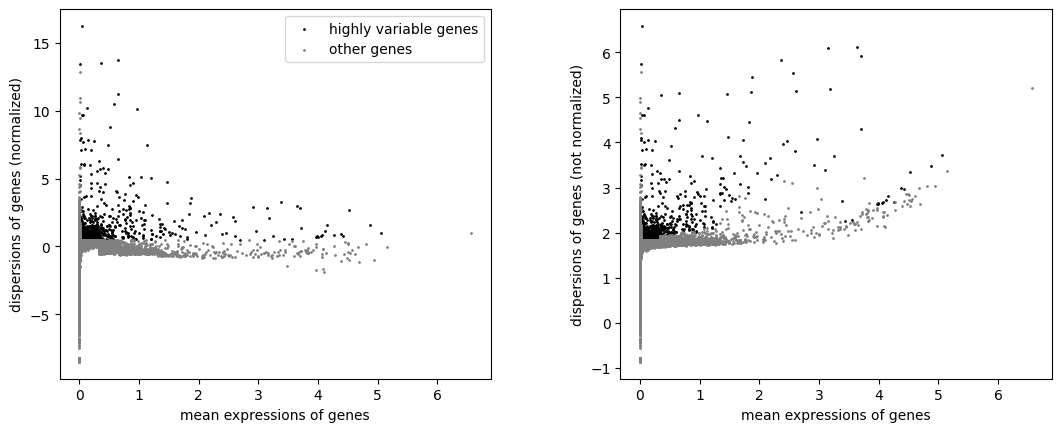

In [41]:
sc.pp.highly_variable_genes(sim_adata, min_mean=0.0125, max_mean=6, min_disp=0.5)
sc.pl.highly_variable_genes(sim_adata)


In [42]:
sim_adata.layers['lognorm'] = sim_adata.X.copy()


In [43]:
sc.pp.scale(sim_adata, max_value=10)


In [44]:
sc.tl.pca(sim_adata, svd_solver='arpack')


/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


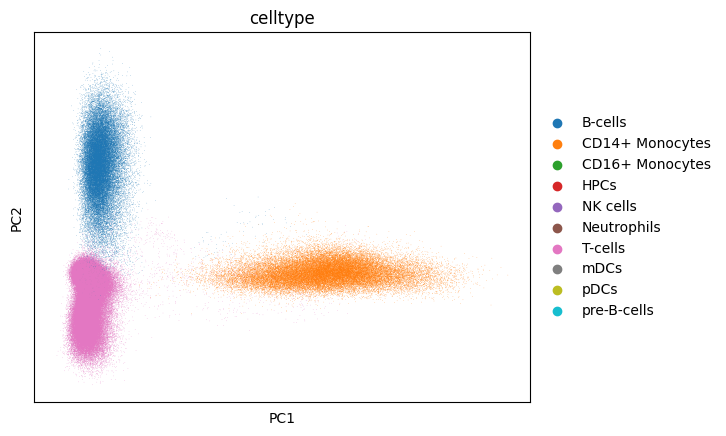

In [45]:
sc.pl.pca(sim_adata, color='celltype')


In [46]:
sim_adata.obs.celltype.value_counts()

T-cells            144590
CD14+ Monocytes     39265
B-cells             39165
CD16+ Monocytes         0
HPCs                    0
NK cells                0
Neutrophils             0
mDCs                    0
pDCs                    0
pre-B-cells             0
Name: celltype, dtype: int64

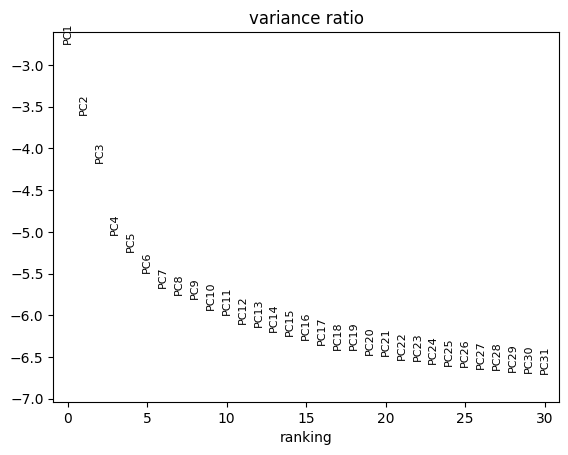

In [47]:
sc.pl.pca_variance_ratio(sim_adata, log=True)


In [48]:
sc.pp.neighbors(sim_adata, n_neighbors=10, n_pcs=20)


In [49]:
sc.tl.umap(sim_adata)

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


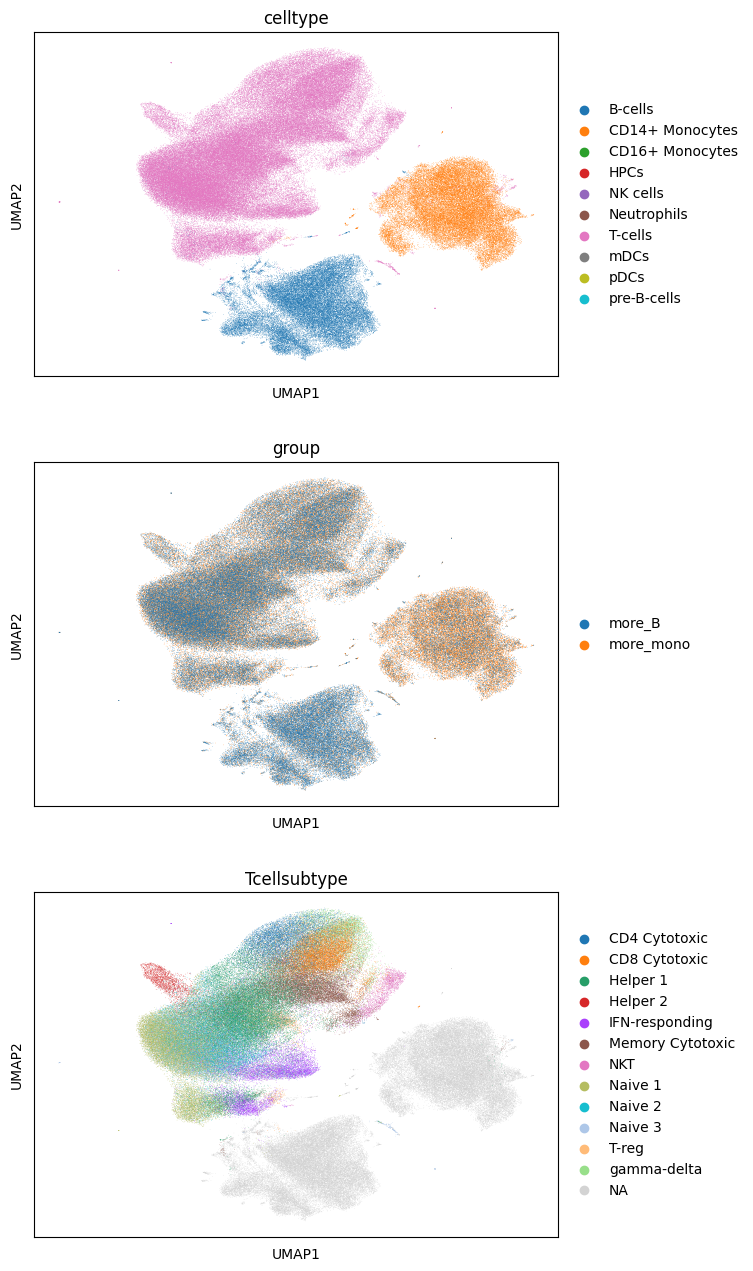

In [50]:
sc.pl.umap(sim_adata, color=['celltype', 'group', 'Tcellsubtype'], ncols=1)


In [52]:
# save adata
sim_adata.write_h5ad("/localdata/rna_rep_learning/scset/props_exp_scvi_adata.h5ad")

In [4]:
sim_adata = sc.read_h5ad("/localdata/rna_rep_learning/scset/props_exp_scvi_adata.h5ad")

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [96]:
#visualize proportions in this dataset
sim_adata.obs.celltype.cat.remove_unused_categories(inplace=True)
celltypecounts = sim_adata.obs.groupby(["patient", "celltype"]).count().reset_index().iloc[:,:3]
celltypecounts = celltypecounts.rename(columns = {celltypecounts.columns[2]:"ncells"})
#celltypecounts['pt_totalcells'] = 
pt_totalcells = celltypecounts.groupby("patient").sum().iloc[:,[0]].reset_index().rename(columns={'ncells':'pt_totalcells'})
celltypecounts = celltypecounts.merge(pt_totalcells, on="patient")
celltypecounts['fraction'] = celltypecounts.ncells / celltypecounts.pt_totalcells
celltypecounts

/tmp/ipykernel_191169/4087099130.py:2: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  sim_adata.obs.celltype.cat.remove_unused_categories(inplace=True)
/tmp/ipykernel_191169/4087099130.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pt_totalcells = celltypecounts.groupby("patient").sum().iloc[:,[0]].reset_index().rename(columns={'ncells':'pt_totalcells'})


patient         celltype  ncells  pt_totalcells  fraction
0       sim_pt1          B-cells      32            441  0.072562
1       sim_pt1  CD14+ Monocytes      98            441  0.222222
2       sim_pt1          T-cells     311            441  0.705215
3       sim_pt2          B-cells      71            455  0.156044
4       sim_pt2  CD14+ Monocytes      84            455  0.184615
...         ...              ...     ...            ...       ...
1495  sim_pt499  CD14+ Monocytes      31            469  0.066098
1496  sim_pt499          T-cells     336            469  0.716418
1497  sim_pt500          B-cells     129            443  0.291196
1498  sim_pt500  CD14+ Monocytes      52            443  0.117381
1499  sim_pt500          T-cells     262            443  0.591422

[1500 rows x 5 columns]

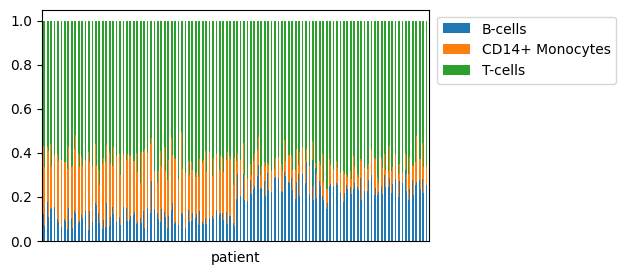

In [99]:
fig, ax = plt.subplots(1,1, figsize=[5,3])
#ax.xaxis.set_tick_params(labelbottom=False)

toplot = celltypecounts[["patient","celltype","fraction"]].pivot(index="patient", columns="celltype", values="fraction").fillna(0).reset_index()
toplot.plot(kind="bar", stacked="true", x="patient", ax=ax, xticks=[])
plt.legend(loc="upper right", bbox_to_anchor=[1.5,1]);

#### pseudobulk of these samples

In [5]:
pseudobulk_counts = pd.DataFrame(sim_adata.layers['counts'], index=sim_adata.obs.patient, columns=sim_adata.var.index).reset_index().groupby("patient").sum()

In [6]:
pseudobulk_lognorm = np.log1p(np.divide(pseudobulk_counts.T, pseudobulk_counts.sum(axis=1)))

In [7]:
# top 100 variable genes
gene_stds = pseudobulk_lognorm.std(axis=1)
topvargenes = gene_stds.sort_values()[-100:].index

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


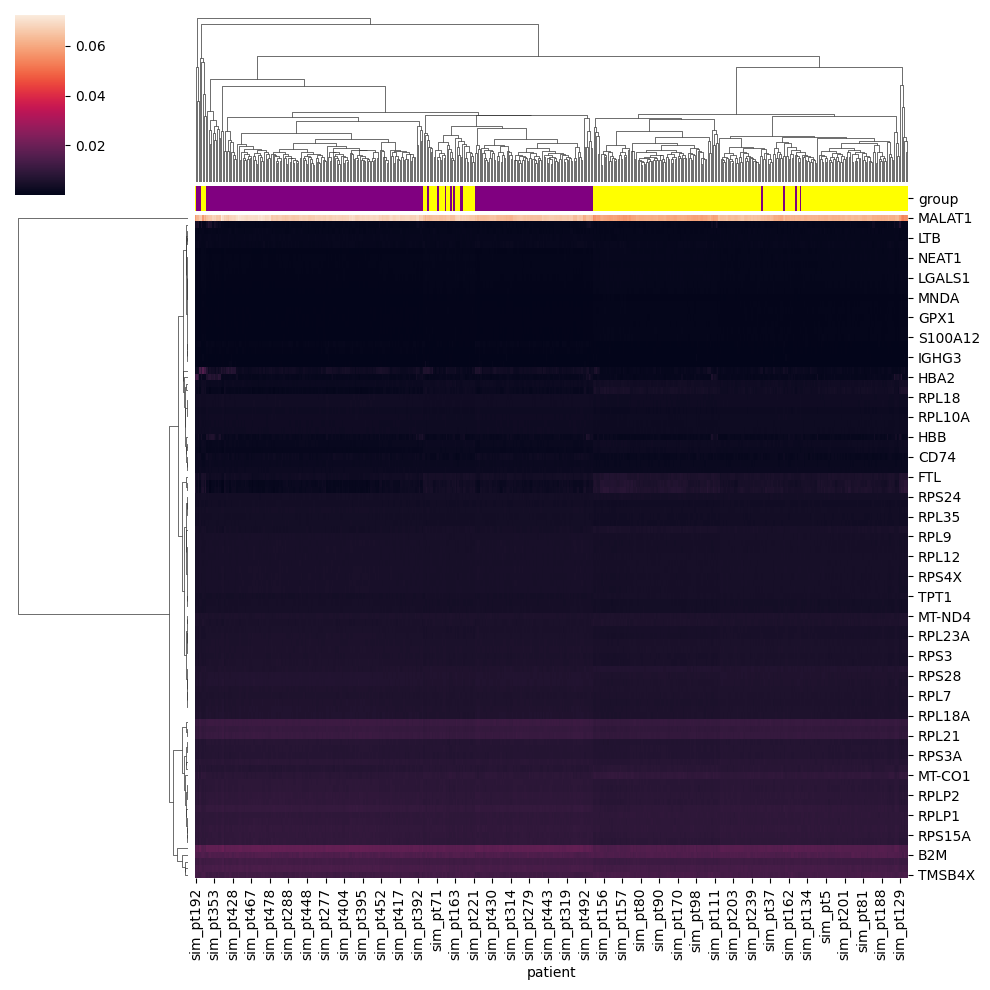

In [15]:
import seaborn as sns
sns.clustermap(pseudobulk_lognorm.loc[topvargenes,:], col_colors=sim_adata.obs[['patient','group']].drop_duplicates().set_index('patient').group.cat.rename_categories({'more_B':'purple', 'more_mono':'yellow'}))

# create progressively harder proportional experiments

### let's do memory cytotoxic, helper 1, cd4 and cd8, and alter the proportions of cd4 and cd8 between responders/non-responders

In [5]:
#temporarily convert to more specific cell types
cd45_adata.obs.celltype = cd45_adata.obs.Tcellsubtype.astype('str').replace('nan',np.NaN).fillna(cd45_adata.obs.celltype.astype('str'))

In [6]:
scvi.model.SCVI.setup_anndata(cd45_adata)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [7]:
#load trained scvi model
with open("/localdata/rna_rep_learning/scset/scvi_data/cd45model.pkl", "rb") as f: # "wb" because we want to write in binary mode
    fullmodel = pickle.load(f)   

In [43]:
tcell_counts = pd.read_csv("zavidij_extras/fig2_T_counts.csv").rename(columns={'Unnamed: 0':'patient'}).set_index("patient").dropna()

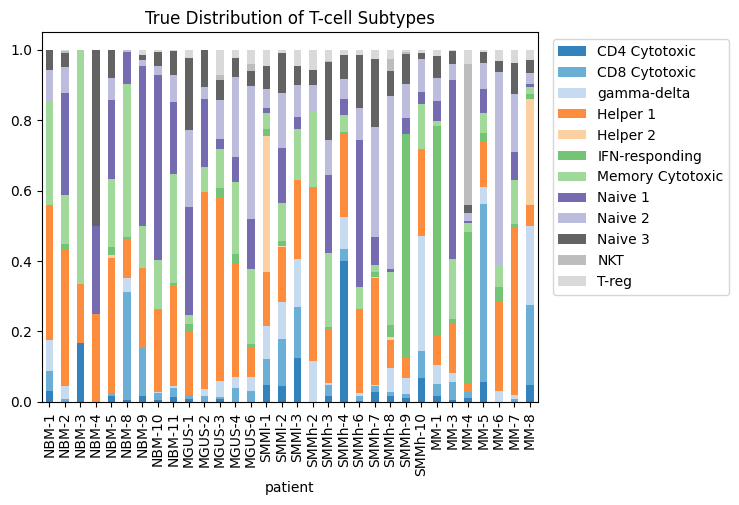

In [98]:
np.divide(tcell_counts.T, tcell_counts.sum(axis=1)).T.reset_index().plot(kind='bar', stacked=True, x="patient", colormap="tab20c")
plt.legend(loc="upper right", bbox_to_anchor=[0,0,1.4,1])
plt.title("True Distribution of T-cell Subtypes");

In [44]:
np.divide(tcell_counts.T, tcell_counts.sum(axis=1)).T.reset_index()

patient  CD4 Cytotoxic  CD8 Cytotoxic  gamma-delta  Helper 1  Helper 2  \
0     NBM-1       0.029412       0.058824     0.088235  0.382353  0.000000   
1     NBM-2       0.000000       0.009050     0.036199  0.384615  0.000000   
2     NBM-3       0.166667       0.000000     0.000000  0.166667  0.000000   
3     NBM-4       0.000000       0.000000     0.000000  0.250000  0.000000   
4     NBM-5       0.016000       0.008000     0.000000  0.384000  0.008000   
5     NBM-8       0.005780       0.306358     0.040462  0.109827  0.000000   
6     NBM-9       0.015152       0.136364     0.000000  0.227273  0.000000   
7    NBM-10       0.004392       0.019034     0.004392  0.234261  0.000000   
8    NBM-11       0.014583       0.025000     0.006250  0.285417  0.000000   
9    MGUS-1       0.007535       0.011841     0.001076  0.176534  0.001076   
10   MGUS-2       0.000000       0.017544     0.017544  0.561404  0.000000   
11   MGUS-3       0.006536       0.006536     0.045752  0.522876  0.000000   
12   MGUS-4       0.000000       0.038095     0.033333  0.319048  0.000000   
13   MGUS-6       0.000000       0.030612     0.040816  0.081633  0.000000   
14   SMMl-1       0.047619       0.073016     0.095238  0.152381  0.387302   
15   SMMl-2       0.045139       0.133681     0.105903  0.156250  0.001736   
16   SMMl-3       0.123596       0.146067     0.134831  0.224719  0.000000   
17   SMMh-2       0.000000       0.000000     0.115942  0.492754  0.000000   
18   SMMh-3       0.015625       0.031250     0.006250  0.150000  0.000000   
19   SMMh-4       0.400877       0.031579     0.092982  0.234211  0.000000   
20   SMMh-6       0.003110       0.013997     0.007776  0.234837  0.000000   
21   SMMh-7       0.026726       0.017817     0.002227  0.305122  0.002227   
22   SMMh-8       0.017544       0.008772     0.070175  0.078947  0.008772   
23   SMMh-9       0.011429       0.011429     0.045714  0.057143  0.000000   
24  SMMh-10       0.068376       0.076923     0.324786  0.247863  0.000000   
25     MM-1       0.016026       0.035256     0.052885  0.081731  0.000000   
26     MM-3       0.004454       0.051225     0.024499  0.140312  0.000000   
27     MM-4       0.009828       0.017199     0.000000  0.027027  0.000000   
28     MM-5       0.054993       0.507959     0.047757  0.128799  0.000000   
29     MM-6       0.000000       0.000000     0.031579  0.252632  0.000000   
30     MM-7       0.000000       0.008086     0.010782  0.474394  0.000000   
31     MM-8       0.048035       0.227074     0.222707  0.061135  0.301310   

    IFN-responding  Memory Cytotoxic   Naive 1   Naive 2   Naive 3       NKT  \
0         0.000000          0.294118  0.000000  0.088235  0.058824  0.000000   
1         0.018100          0.140271  0.289593  0.072398  0.040724  0.004525   
2         0.000000          0.666667  0.000000  0.000000  0.000000  0.000000   
3         0.000000          0.000000  0.250000  0.000000  0.500000  0.000000   
4         0.024000          0.192000  0.224000  0.064000  0.080000  0.000000   
5         0.005780          0.433526  0.092486  0.005780  0.000000  0.000000   
6         0.000000          0.121212  0.454545  0.015152  0.015152  0.000000   
7         0.001464          0.139092  0.524158  0.026354  0.040996  0.000000   
8         0.006250          0.310417  0.204167  0.077083  0.066667  0.000000   
9         0.023681          0.025834  0.304629  0.220667  0.202368  0.000000   
10        0.000000          0.070175  0.192982  0.035088  0.105263  0.000000   
11        0.026144          0.111111  0.026144  0.111111  0.058824  0.013072   
12        0.028571          0.204762  0.071429  0.228571  0.052381  0.000000   
13        0.010204          0.214286  0.142857  0.377551  0.040816  0.020408   
14        0.019048          0.044444  0.015873  0.053968  0.063492  0.000000   
15        0.013889          0.109375  0.154514  0.156250  0.114583  0.000000   
16        0.000000          0.146067  0.033708  0.089888  0.056180  0

In [6]:
cell_types = ["CD4 Cytotoxic", "CD8 Cytotoxic", "Helper 1", "Memory Cytotoxic", "B-cells", "CD14+ Monocytes"]
dir_strength = 50
cell_type_dirichlet_concentrations_1={"CD4 Cytotoxic":0.05*dir_strength, "CD8 Cytotoxic":0.15*dir_strength, "Helper 1":0.2*dir_strength, "Memory Cytotoxic":0.2*dir_strength, "B-cells":0.2*dir_strength, "CD14+ Monocytes":0.2*dir_strength}
cell_type_dirichlet_concentrations_2={"CD4 Cytotoxic":0.15*dir_strength, "CD8 Cytotoxic":0.05*dir_strength, "Helper 1":0.2*dir_strength, "Memory Cytotoxic":0.2*dir_strength, "B-cells":0.2*dir_strength, "CD14+ Monocytes":0.2*dir_strength}
npatients = 500
mean_ncells = 445
total_cells_pp = scipy.stats.poisson.rvs(mean_ncells, size=npatients)
sim_counts_Tsubtypes = np.empty((np.sum(total_cells_pp), cd45_adata.shape[1]))
verbose=False

cell_index = 0
for i in np.arange(npatients):
    if i % 100 == 0:
        print(i)
    if i <=(npatients/2-1):    
        sim_counts_Tsubtypes[cell_index:cell_index+total_cells_pp[i],:], joint_obs_Tsubtypes = sample_pt_cells_scvi(cd45_adata, fullmodel, cell_types, cell_type_dirichlet_concentrations_1, total_cells_pp[i], ptname="sim_pt{}".format(i+1), groupname="group1")

    else:
        sim_counts_Tsubtypes[cell_index:cell_index+total_cells_pp[i],:], joint_obs_Tsubtypes = sample_pt_cells_scvi(cd45_adata, fullmodel, cell_types, cell_type_dirichlet_concentrations_2, total_cells_pp[i], ptname="sim_pt{}".format(i+1), groupname="group2")
        
    cell_index += total_cells_pp[i]
    if i==0:
        sim_metadata_Tsubtypes = joint_obs_Tsubtypes.copy()
    else: 
        sim_metadata_Tsubtypes = pd.concat([sim_metadata_Tsubtypes, joint_obs_Tsubtypes], axis=0)


0
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
100
200
300
400


In [143]:
celltype_counts = sim_metadata_Tsubtypes[['celltype','group','patient']].groupby(["group","patient","celltype"]).size().unstack()
celltype_counts

celltype          B-cells  CD14+ Monocytes  CD4 Cytotoxic  CD8 Cytotoxic  \
group  patient                                                             
group1 sim_pt1       89.0             58.0           39.0           48.0   
       sim_pt10      84.0             78.0           14.0           75.0   
       sim_pt100     66.0             99.0           40.0           40.0   
       sim_pt101     91.0             68.0            8.0           95.0   
       sim_pt102     43.0            115.0            6.0          123.0   
...                   ...              ...            ...            ...   
group2 sim_pt496     96.0            120.0           20.0           20.0   
       sim_pt497     70.0            124.0           78.0            6.0   
       sim_pt498     37.0             85.0           73.0            5.0   
       sim_pt499    102.0             77.0           75.0           13.0   
       sim_pt500     72.0            135.0           56.0           33.0   

celltype          Helper 1  Memory Cytotoxic  
group  patient                                
group1 sim_pt1        63.0             112.0  
       sim_pt10      111.0              67.0  
       sim_pt100      95.0             128.0  
       sim_pt101      77.0              70.0  
       sim_pt102      82.0              62.0  
...                    ...               ...  
group2 sim_pt496     112.0              90.0  
       sim_pt497      91.0              45.0  
       sim_pt498     164.0              83.0  
       sim_pt499      97.0              82.0  
       sim_pt500     110.0              48.0  

[500 rows x 6 columns]

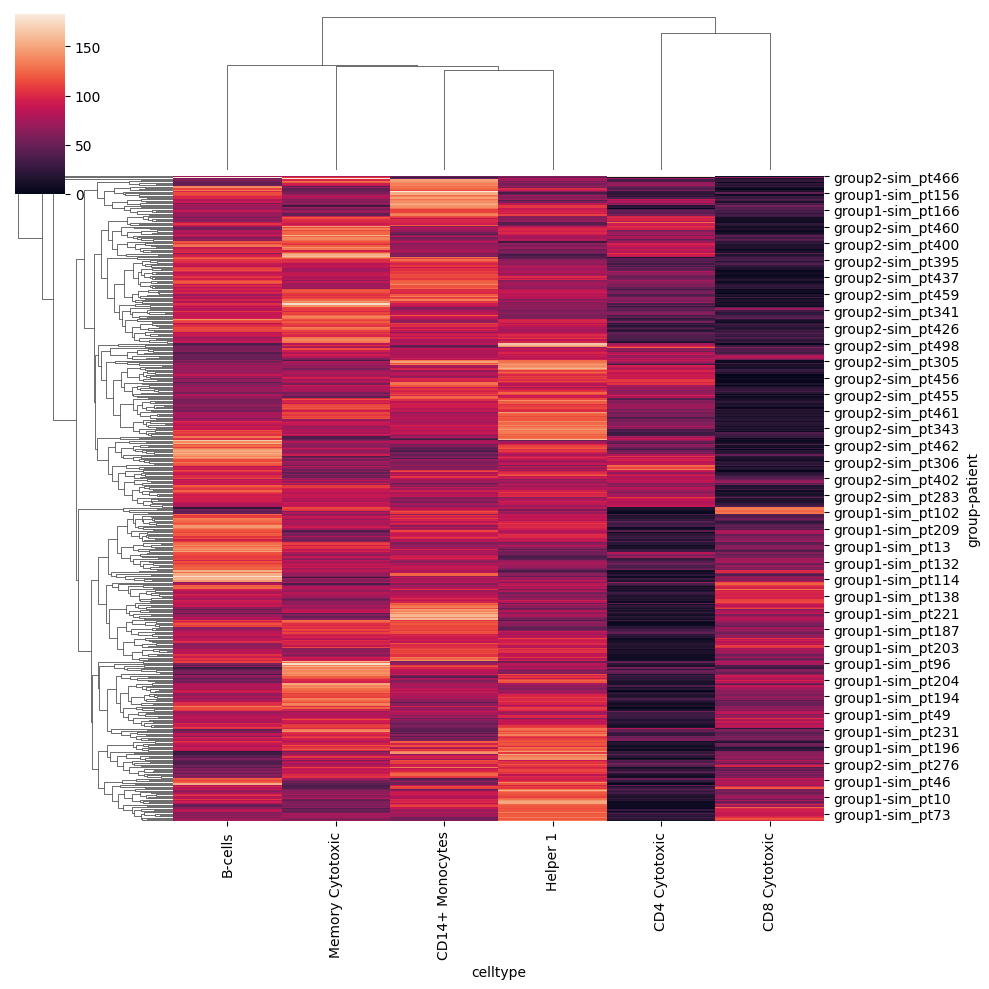

In [146]:
sns.clustermap(celltype_counts.fillna(0)) #to color rows: celltype_counts.reset_index.group.map({"group1":purple, "group2":yellow})

In [ ]:
np.divide(celltype_counts.T, celltype_counts.sum(axis=1)).T.reset_index().plot(kind='bar', stacked=True, x="patient", colormap="tab20c")
plt.legend(loc="upper right", bbox_to_anchor=[0,0,1.4,1])
plt.title("Distribution of Cell Subtypes in Sim Data");

In [ ]:
# pseudobulk of these sample

In [7]:
pseudobulk_counts = pd.DataFrame(sim_counts_Tsubtypes, index=sim_metadata_Tsubtypes.patient, columns=cd45_adata.var.index).reset_index().groupby("patient").sum()

In [8]:
pseudobulk_lognorm = np.log1p(np.divide(pseudobulk_counts.T, pseudobulk_counts.sum(axis=1)))

In [9]:
# top 100 variable genes
gene_stds = pseudobulk_lognorm.std(axis=1)
topvargenes = gene_stds.sort_values()[-100:].index

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


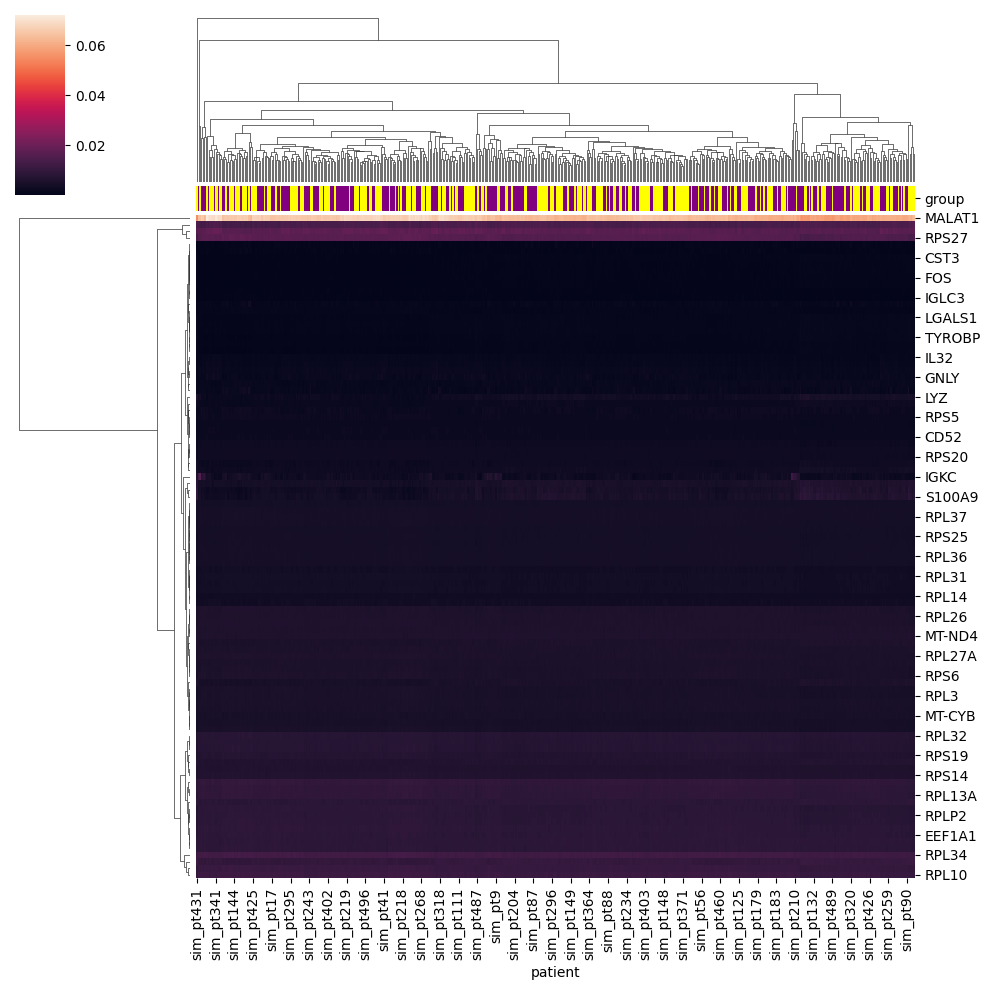

In [10]:
import seaborn as sns
sns.clustermap(pseudobulk_lognorm.loc[topvargenes,:], col_colors=sim_metadata_Tsubtypes[['patient','group']].drop_duplicates().set_index('patient').group.map({'group1':'purple', 'group2':'yellow'}))



In [11]:
sim_adata = sc.AnnData(sim_counts_Tsubtypes, obs=sim_metadata_Tsubtypes, var = cd45_adata.var)

sim_adata.layers['counts'] = sim_adata.X.copy()

sc.pp.normalize_total(sim_adata, target_sum=1e4)


/tmp/ipykernel_1047747/2623845696.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  sim_adata = sc.AnnData(sim_counts_Tsubtypes, obs=sim_metadata_Tsubtypes, var = cd45_adata.var)
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [12]:
sc.pp.log1p(sim_adata)


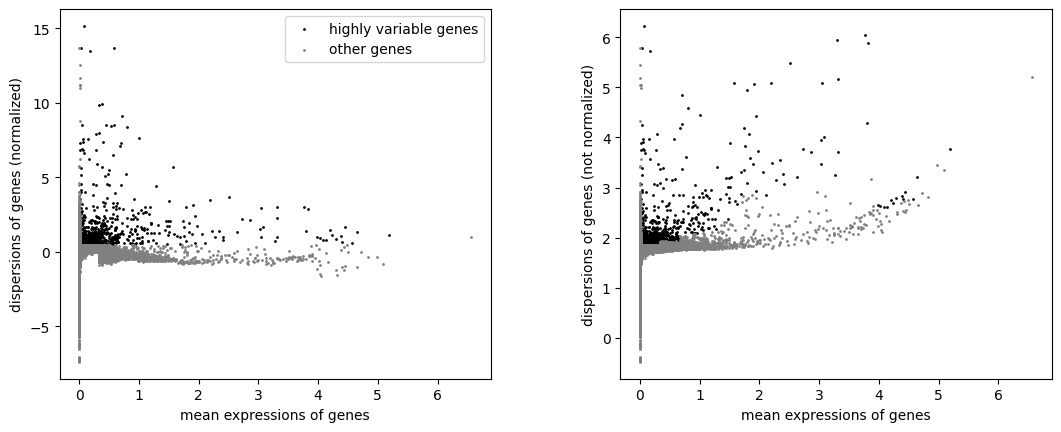

In [13]:
sc.pp.highly_variable_genes(sim_adata, min_mean=0.0125, max_mean=6, min_disp=0.5)
sc.pl.highly_variable_genes(sim_adata)


In [14]:
sim_adata.layers['lognorm'] = sim_adata.X.copy()


In [15]:
sc.pp.scale(sim_adata, max_value=10)


In [16]:
sc.tl.pca(sim_adata, svd_solver='arpack')


/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


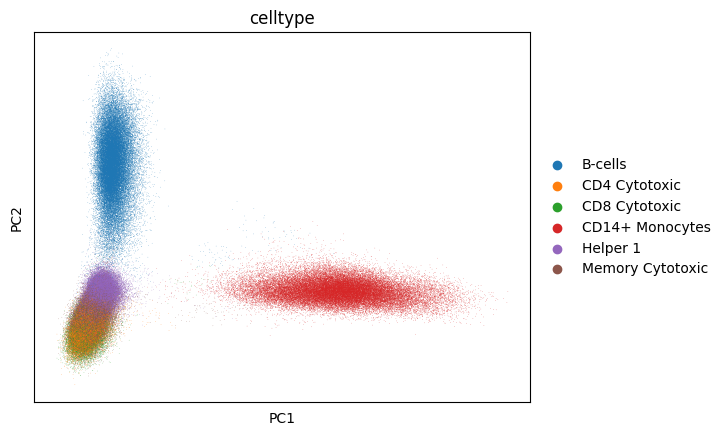

In [17]:
sc.pl.pca(sim_adata, color='celltype')


In [18]:
sim_adata.obs.celltype.value_counts()

CD14+ Monocytes     44912
Memory Cytotoxic    44821
Helper 1            44309
B-cells             43899
CD8 Cytotoxic       22843
CD4 Cytotoxic       21833
Name: celltype, dtype: int64

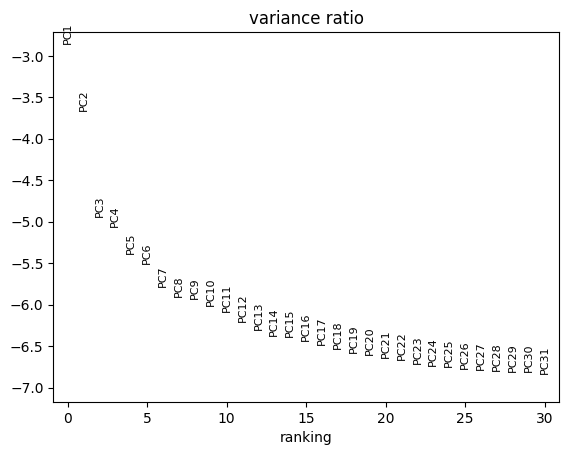

In [19]:
sc.pl.pca_variance_ratio(sim_adata, log=True)


In [20]:
sc.pp.neighbors(sim_adata, n_neighbors=10, n_pcs=20)


In [21]:
sc.tl.umap(sim_adata)

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


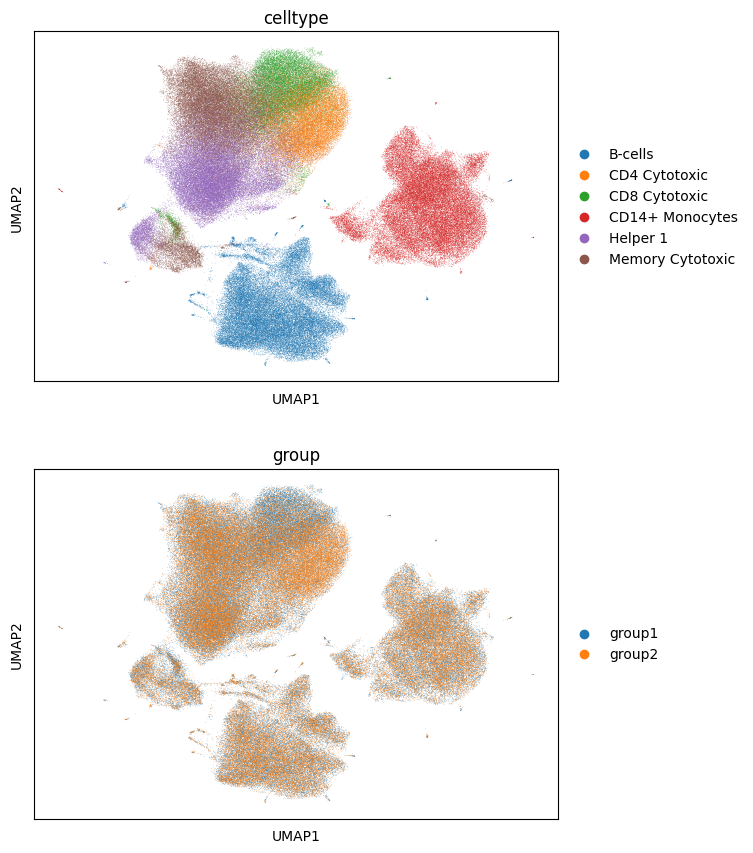

In [24]:
sc.pl.umap(sim_adata, color=['celltype', 'group'], ncols=1)


In [23]:
# save adata
sim_adata.write_h5ad("/localdata/rna_rep_learning/scset/props_exp_scvi_tsubtypes_adata.h5ad")

In [3]:
sim_adata = sc.read_h5ad("/localdata/rna_rep_learning/scset/props_exp_scvi_tsubtypes_adata.h5ad")

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
def viz_props(obs_df):
    #visualize proportions in this dataset
    obs_df.celltype.cat.remove_unused_categories(inplace=True)
    celltypecounts = obs_df.groupby(["patient", "celltype"]).count().reset_index().iloc[:,:3]
    celltypecounts = celltypecounts.rename(columns = {celltypecounts.columns[2]:"ncells"})
    #celltypecounts['pt_totalcells'] = 
    pt_totalcells = celltypecounts.groupby("patient").sum().iloc[:,[0]].reset_index().rename(columns={'ncells':'pt_totalcells'})
    celltypecounts = celltypecounts.merge(pt_totalcells, on="patient")
    celltypecounts['fraction'] = celltypecounts.ncells / celltypecounts.pt_totalcells
    celltypecounts
    
    fig, ax = plt.subplots(1,1, figsize=[5,3])

    toplot = celltypecounts[["patient","celltype","fraction"]].pivot(index="patient", columns="celltype", values="fraction").fillna(0).reset_index()
    toplot.plot(kind="bar", stacked="true", x="patient", ax=ax, xticks=[])
    plt.legend(loc="upper right", bbox_to_anchor=[1.5,1]);

/tmp/ipykernel_2414616/311809603.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  obs_df.celltype.cat.remove_unused_categories(inplace=True)
/tmp/ipykernel_2414616/311809603.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pt_totalcells = celltypecounts.groupby("patient").sum().iloc[:,[0]].reset_index().rename(columns={'ncells':'pt_totalcells'})


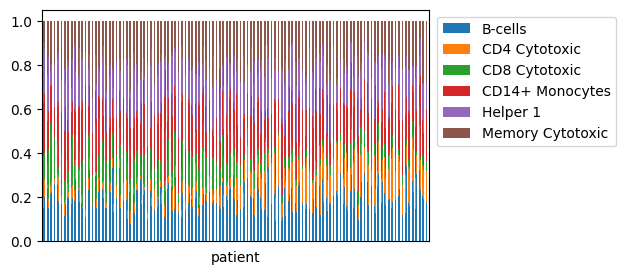

In [9]:
viz_props(sim_adata.obs)

### make it slightly less challenging (memory cytotoxic, helper 1, cd4 and cd8, and alter the proportions of cd4 and cd8 between responders/non-responders)

In [4]:
#temporarily convert to more specific cell types
cd45_adata.obs.celltype = cd45_adata.obs.Tcellsubtype.astype('str').replace('nan',np.NaN).fillna(cd45_adata.obs.celltype.astype('str'))

In [5]:
scvi.model.SCVI.setup_anndata(cd45_adata)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
#load trained scvi model
with open("/localdata/rna_rep_learning/scset/scvi_data/cd45model.pkl", "rb") as f: # "wb" because we want to write in binary mode
    fullmodel = pickle.load(f)   

In [7]:
cell_types = ["CD4 Cytotoxic", "CD8 Cytotoxic", "Helper 1", "Memory Cytotoxic", "B-cells", "CD14+ Monocytes"]
dir_strength = 50
cell_type_dirichlet_concentrations_1={"CD4 Cytotoxic":0.1*dir_strength, "CD8 Cytotoxic":0.2*dir_strength, "Helper 1":0.175*dir_strength, "Memory Cytotoxic":0.175*dir_strength, "B-cells":0.175*dir_strength, "CD14+ Monocytes":0.175*dir_strength}
cell_type_dirichlet_concentrations_2={"CD4 Cytotoxic":0.2*dir_strength, "CD8 Cytotoxic":0.1*dir_strength, "Helper 1":0.175*dir_strength, "Memory Cytotoxic":0.175*dir_strength, "B-cells":0.175*dir_strength, "CD14+ Monocytes":0.175*dir_strength}
npatients = 500
mean_ncells = 445
total_cells_pp = scipy.stats.poisson.rvs(mean_ncells, size=npatients)
sim_counts_Tsubtypes = np.empty((np.sum(total_cells_pp), cd45_adata.shape[1]))
verbose=False

cell_index = 0
for i in np.arange(npatients):
    if i % 100 == 0:
        print(i)
    if i <=(npatients/2-1):    
        sim_counts_Tsubtypes[cell_index:cell_index+total_cells_pp[i],:], joint_obs_Tsubtypes = sample_pt_cells_scvi(cd45_adata, fullmodel, cell_types, cell_type_dirichlet_concentrations_1, total_cells_pp[i], ptname="sim_pt{}".format(i+1), groupname="group1")

    else:
        sim_counts_Tsubtypes[cell_index:cell_index+total_cells_pp[i],:], joint_obs_Tsubtypes = sample_pt_cells_scvi(cd45_adata, fullmodel, cell_types, cell_type_dirichlet_concentrations_2, total_cells_pp[i], ptname="sim_pt{}".format(i+1), groupname="group2")
        
    cell_index += total_cells_pp[i]
    if i==0:
        sim_metadata_Tsubtypes = joint_obs_Tsubtypes.copy()
    else: 
        sim_metadata_Tsubtypes = pd.concat([sim_metadata_Tsubtypes, joint_obs_Tsubtypes], axis=0)


0
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
100
200
300
400


In [8]:
celltype_counts = sim_metadata_Tsubtypes[['celltype','group','patient']].groupby(["group","patient","celltype"]).size().unstack()
celltype_counts

celltype          B-cells  CD14+ Monocytes  CD4 Cytotoxic  CD8 Cytotoxic  \
group  patient                                                             
group1 sim_pt1         42              116             17            126   
       sim_pt10        52              115            103             59   
       sim_pt100      120               82             15             71   
       sim_pt101      135               75             43             81   
       sim_pt102       87               78             30            114   
...                   ...              ...            ...            ...   
group2 sim_pt496       53               76             74             38   
       sim_pt497       83              138             77             49   
       sim_pt498       59              112             99             54   
       sim_pt499       82               69             54             40   
       sim_pt500       87               46            103             39   

celltype          Helper 1  Memory Cytotoxic  
group  patient                                
group1 sim_pt1          78                85  
       sim_pt10         47                76  
       sim_pt100       117                54  
       sim_pt101        38                77  
       sim_pt102        66                44  
...                    ...               ...  
group2 sim_pt496        86                98  
       sim_pt497        60                51  
       sim_pt498        76                83  
       sim_pt499       127                59  
       sim_pt500        94                69  

[500 rows x 6 columns]

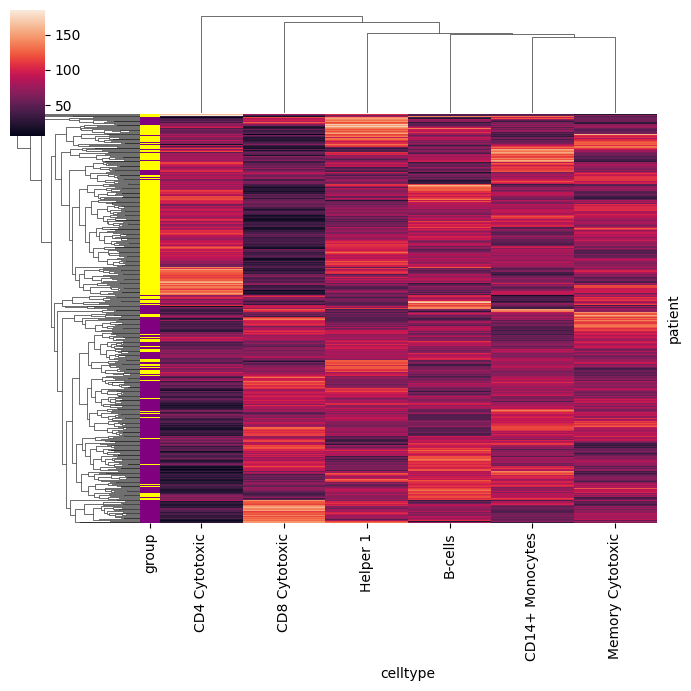

In [9]:
sns.clustermap(celltype_counts.reset_index().drop("group", axis=1).set_index("patient").fillna(0), row_colors=celltype_counts.reset_index().set_index("patient").group.map({"group1":"purple", "group2":"yellow"}), yticklabels=False, figsize=(7,7))

In [15]:
# pseudobulk of these sample

pseudobulk_counts = pd.DataFrame(sim_counts_Tsubtypes, index=sim_metadata_Tsubtypes.patient, columns=cd45_adata.var.index).reset_index().groupby("patient").sum()

pseudobulk_lognorm = np.log1p(np.divide(pseudobulk_counts.T, pseudobulk_counts.sum(axis=1)))

# top 100 variable genes
gene_stds = pseudobulk_lognorm.std(axis=1)
topvargenes = gene_stds.sort_values()[-100:].index

import seaborn as sns
sns.clustermap(pseudobulk_lognorm.loc[topvargenes,:], figsize=(7,7), col_colors=sim_metadata_Tsubtypes[['patient','group']].drop_duplicates().set_index('patient').group.map({'group1':'purple', 'group2':'yellow'}))



In [10]:
sim_adata = sc.AnnData(sim_counts_Tsubtypes, obs=sim_metadata_Tsubtypes, var = cd45_adata.var)

sim_adata.layers['counts'] = sim_adata.X.copy()

sc.pp.normalize_total(sim_adata, target_sum=1e4)


/tmp/ipykernel_2877351/2623845696.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  sim_adata = sc.AnnData(sim_counts_Tsubtypes, obs=sim_metadata_Tsubtypes, var = cd45_adata.var)
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [11]:
sc.pp.log1p(sim_adata)


In [ ]:
sc.pp.highly_variable_genes(sim_adata, min_mean=0.0125, max_mean=6, min_disp=0.5)
sc.pl.highly_variable_genes(sim_adata)


In [ ]:
sim_adata.layers['lognorm'] = sim_adata.X.copy()


In [ ]:
sc.pp.scale(sim_adata, max_value=10)


In [ ]:
sc.tl.pca(sim_adata, svd_solver='arpack')


In [ ]:
sc.pl.pca(sim_adata, color='celltype')


In [ ]:
sim_adata.obs.celltype.value_counts()

In [ ]:
sc.pl.pca_variance_ratio(sim_adata, log=True)


In [37]:
sc.pp.neighbors(sim_adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(sim_adata)

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


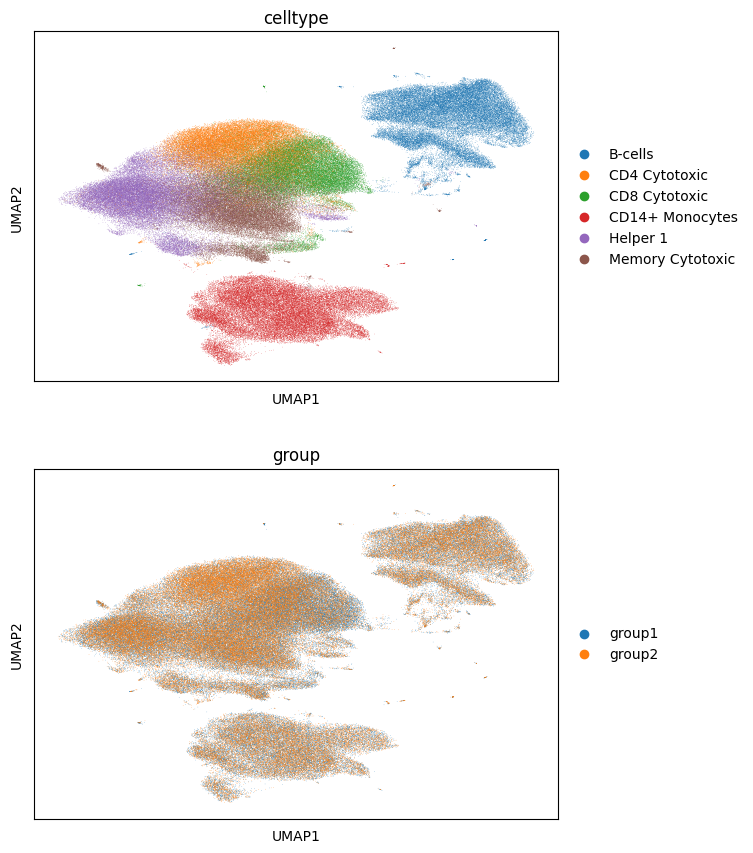

In [38]:
sc.pl.umap(sim_adata, color=['celltype', 'group'], ncols=1)


In [ ]:
# save adata
sim_adata.write_h5ad("/localdata/rna_rep_learning/scset/props_exp_scvi_tsubtypes_0.2vs0.1_adata_v2.h5ad")

In [40]:
del sim_adata, sim_counts_Tsubtypes

In [ ]:
sim_adata = sc.read_h5ad("/localdata/rna_rep_learning/scset/props_exp_scvi_tsubtypes_adata.h5ad")

In [ ]:
viz_props(sim_adata.obs)

## if I sample 50 version of 100 B and T cells resp., how similar are those cells to each others?

In [134]:
n_samples=50

In [135]:
Bcellsamples = Bcellmodel.posterior_predictive_sample(indices=np.arange(100), n_samples=n_samples)

In [136]:
Tcellsamples = Tcellmodel.posterior_predictive_sample(indices=np.arange(100), n_samples=n_samples)

In [137]:
full_data = np.concatenate((np.concatenate([Bcellsamples[:,:,i] for i in np.arange(n_samples)]), np.concatenate([Tcellsamples[:,:,i] for i in np.arange(n_samples)])), axis=0)

In [138]:
joint_adata = sc.AnnData(
    full_data, 
    obs = pd.DataFrame({"celltype": np.concatenate((np.repeat("B", Bcellsamples.reshape(-1, cd45_adata.shape[1]).shape[0]),
                                                    np.repeat("T", Tcellsamples.reshape(-1, cd45_adata.shape[1]).shape[0])))}),
    var = cd45_adata.var
)


/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


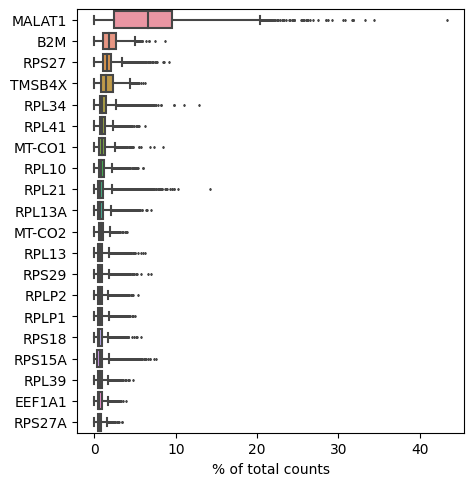

In [139]:
sc.pl.highest_expr_genes(joint_adata, n_top=20, )


In [140]:
sc.pp.filter_cells(joint_adata, min_genes=200)
sc.pp.filter_genes(joint_adata, min_cells=3)

In [141]:
joint_adata.var['mt'] = joint_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(joint_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

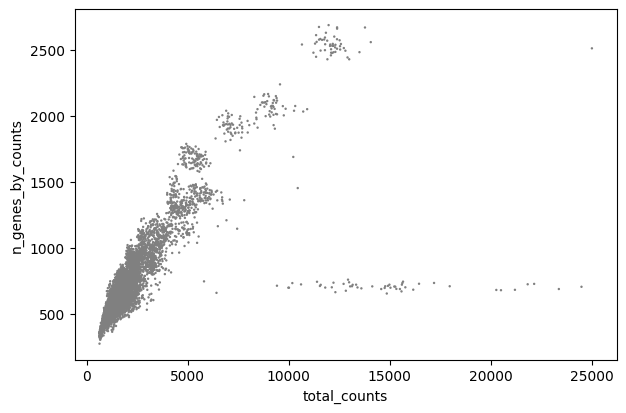

In [142]:
sc.pl.scatter(joint_adata, x='total_counts', y='n_genes_by_counts')

In [143]:
joint_adata.layers['counts'] = joint_adata.X.copy()

sc.pp.normalize_total(joint_adata, target_sum=1e4)

In [144]:
sc.pp.log1p(joint_adata)


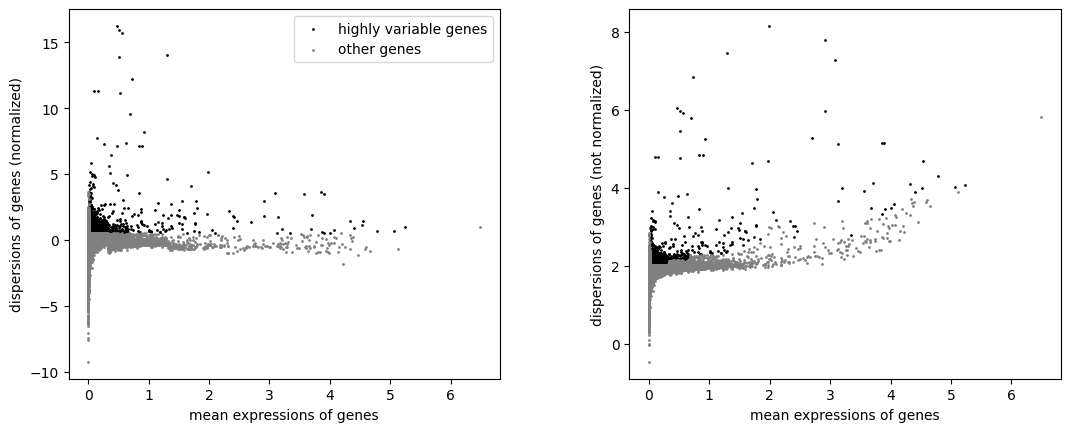

In [145]:
sc.pp.highly_variable_genes(joint_adata, min_mean=0.0125, max_mean=6, min_disp=0.5)
sc.pl.highly_variable_genes(joint_adata)


In [146]:
joint_adata.layers['lognorm'] = joint_adata.X.copy()


In [147]:
sc.pp.scale(joint_adata, max_value=10)


In [148]:
sc.tl.pca(joint_adata, svd_solver='arpack')


/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


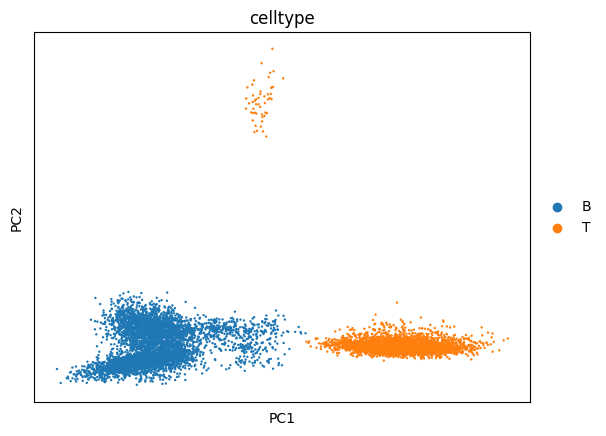

In [149]:
sc.pl.pca(joint_adata, color='celltype')


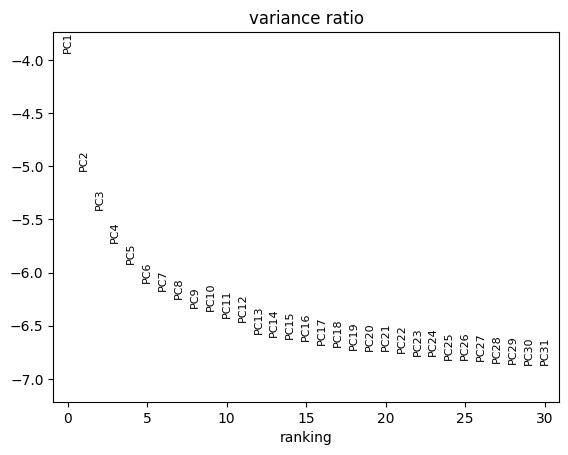

In [150]:
sc.pl.pca_variance_ratio(joint_adata, log=True)


In [151]:
sc.pp.neighbors(joint_adata, n_neighbors=10, n_pcs=20)


In [152]:
sc.tl.umap(joint_adata)

In [154]:
sc.tl.leiden(joint_adata)

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


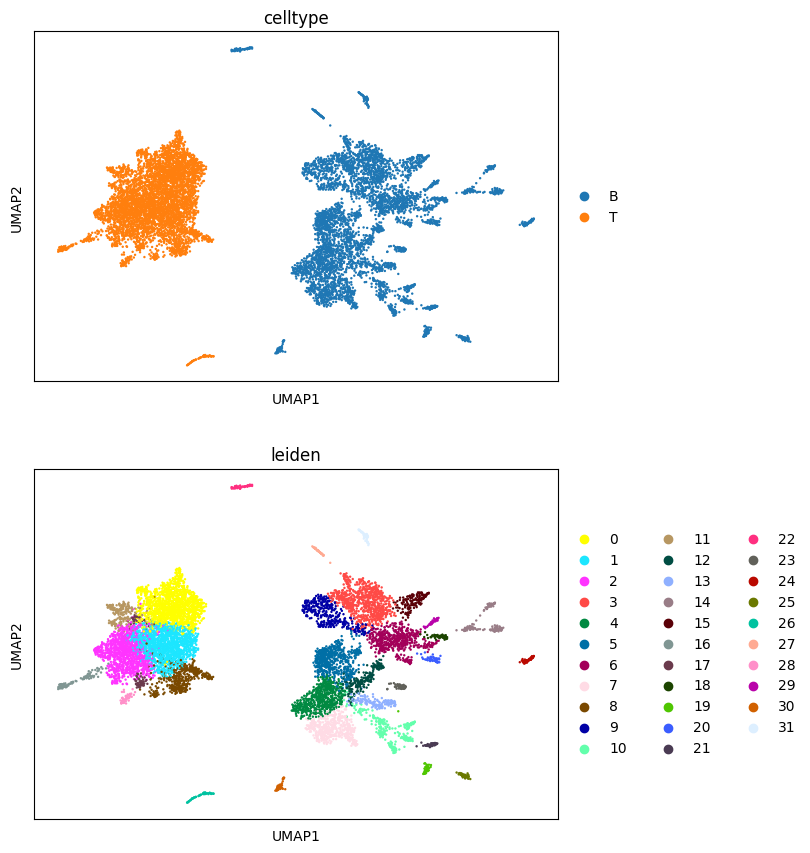

In [155]:
sc.pl.umap(joint_adata, color=['celltype', 'leiden'], ncols=1)


In [157]:
joint_adata.obs.groupby(["leiden"]).size()

leiden
0     1506
1     1397
2     1143
3      804
4      614
5      611
6      559
7      478
8      441
9      373
10     291
11     220
12     211
13     156
14     149
15     148
16      97
17      96
18      56
19      51
20      51
21      50
22      50
23      50
24      50
25      50
26      50
27      50
28      50
29      50
30      49
31      49
dtype: int64

## if I sample 20 samples per cell for all cells, how does it look?

In [162]:
n_samples = 20

In [163]:
Bcellsamples = Bcellmodel.posterior_predictive_sample(n_samples=n_samples)

In [164]:
Tcellsamples = Tcellmodel.posterior_predictive_sample(n_samples=n_samples)

In [165]:
full_data = np.concatenate((np.concatenate([Bcellsamples[:,:,i] for i in np.arange(n_samples)]), np.concatenate([Tcellsamples[:,:,i] for i in np.arange(n_samples)])), axis=0)

In [166]:
joint_adata = sc.AnnData(
    full_data, 
    obs = pd.DataFrame({"celltype": np.concatenate((np.repeat("B", Bcellsamples.reshape(-1, cd45_adata.shape[1]).shape[0]),
                                                    np.repeat("T", Tcellsamples.reshape(-1, cd45_adata.shape[1]).shape[0])))}),
    var = cd45_adata.var
)


/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


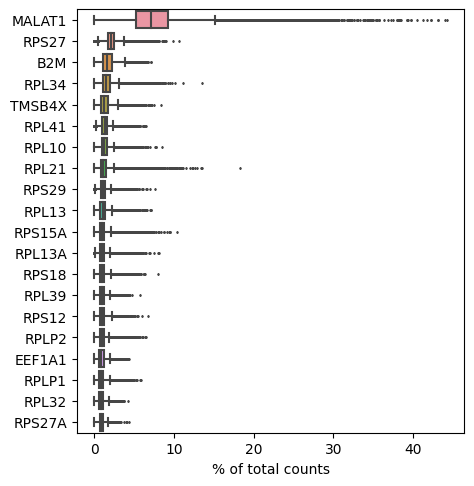

In [167]:
sc.pl.highest_expr_genes(joint_adata, n_top=20, )


In [169]:
sc.pp.filter_cells(joint_adata, min_genes=200)
sc.pp.filter_genes(joint_adata, min_cells=3)

In [170]:
joint_adata.var['mt'] = joint_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(joint_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

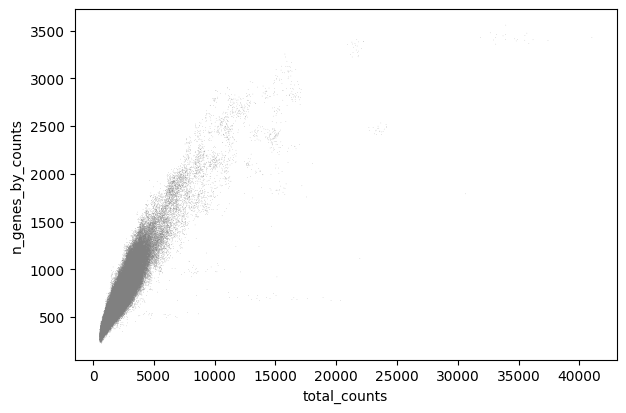

In [171]:
sc.pl.scatter(joint_adata, x='total_counts', y='n_genes_by_counts')

In [172]:
joint_adata.layers['counts'] = joint_adata.X.copy()

sc.pp.normalize_total(joint_adata, target_sum=1e4)

In [173]:
sc.pp.log1p(joint_adata)


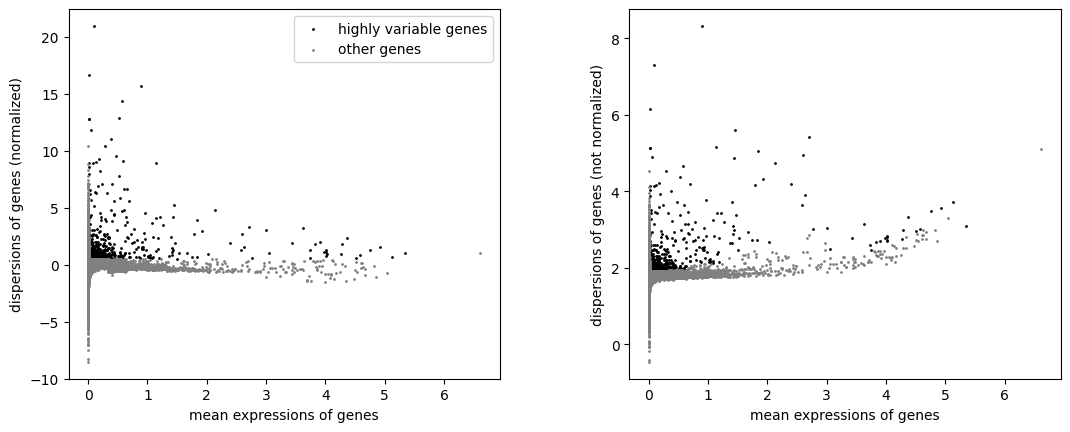

In [174]:
sc.pp.highly_variable_genes(joint_adata, min_mean=0.0125, max_mean=6, min_disp=0.5)
sc.pl.highly_variable_genes(joint_adata)


In [175]:
joint_adata.layers['lognorm'] = joint_adata.X.copy()


In [176]:
sc.pp.scale(joint_adata, max_value=10)


In [177]:
sc.tl.pca(joint_adata, svd_solver='arpack')


/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


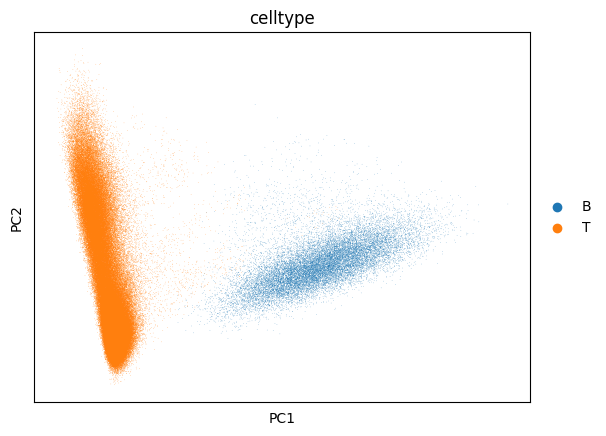

In [178]:
sc.pl.pca(joint_adata, color='celltype')


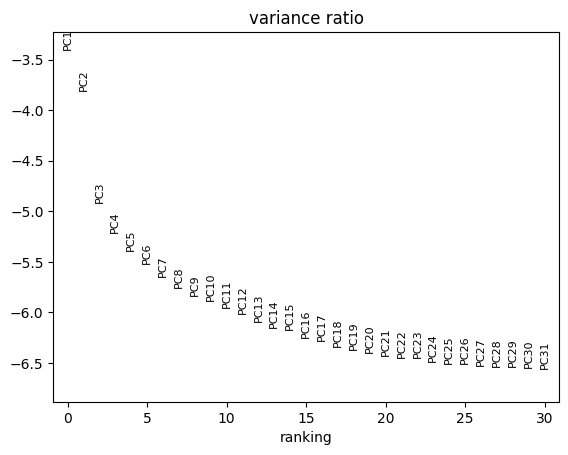

In [179]:
sc.pl.pca_variance_ratio(joint_adata, log=True)


In [180]:
sc.pp.neighbors(joint_adata, n_neighbors=10, n_pcs=20)


In [181]:
sc.tl.umap(joint_adata)

In [182]:
sc.tl.leiden(joint_adata)

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


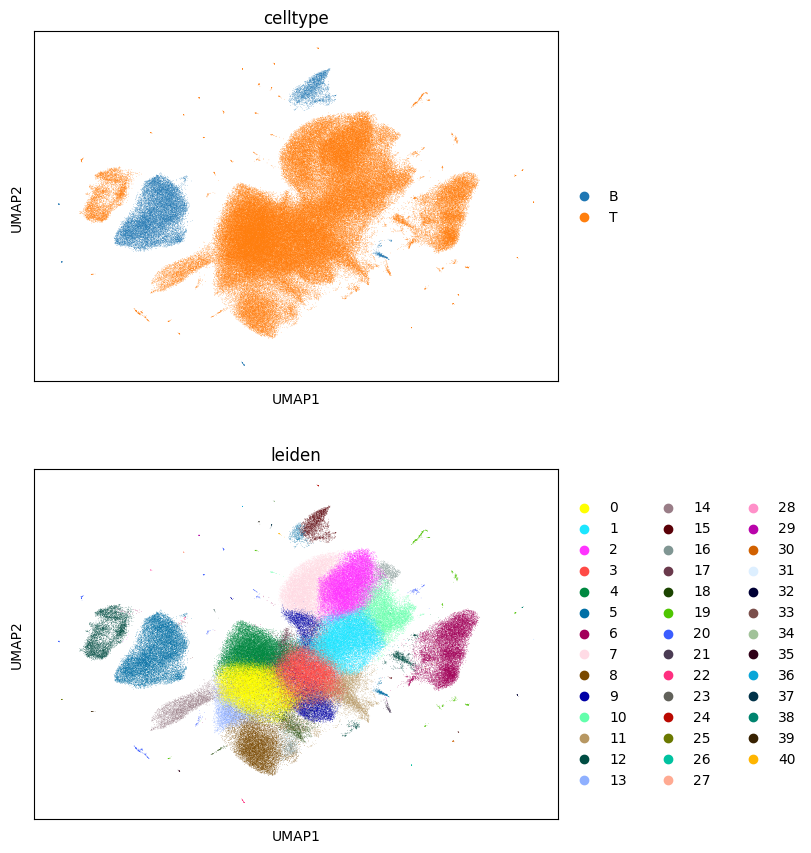

In [183]:
sc.pl.umap(joint_adata, color=['celltype', 'leiden'], ncols=1)


In [184]:
joint_adata.obs.groupby(["leiden"]).size()

leiden
0     30814
1     21931
2     21345
3     20993
4     19818
5     17680
6     15074
7     12883
8     10794
9      8636
10     8636
11     7506
12     6554
13     5521
14     5120
15     2320
16     1992
17     1932
18     1894
19      497
20      438
21      124
22       60
23       21
24       20
25       20
26       20
27       20
28       20
29       20
30       20
31       20
32       20
33       20
34       20
35       20
36       20
37       20
38       20
39       19
40       18
dtype: int64